# Дерево принятия решений

## Введение
Дерево принятия решений (также называют деревом классификации или регрессионным деревом) — средство поддержки принятия решений, использующееся в машинном обучении, анализе данных и статистике. Структура дерева представляет собой «листья» и «ветки». На рёбрах («ветках») дерева решения записаны признаки, от которых зависит целевая функция, в «листьях» записаны значения целевой функции, а в остальных узлах — признаки, по которым различаются случаи. Чтобы классифицировать новый случай, надо спуститься по дереву до листа и выдать соответствующее значение.

Стоит отметить, что данный алгоритм может быть использован как для решения задачи регрессии, так и задачи классификации.

>Почему в реальных задачах бизнеса по прежнему любят применять подобные алгоритмы из классического ML, если можно обучить модель с более высокими метриками качества из ряда алгоритов грубокого обучения?

На самом деле ответ достаточно простой: зачастую бизнесу очень важная такая составляющая, как *интерпретируемость результатов*. Если модель обладает такой способностью, то мы можем объяснить почему тот или иной объект отнесен к тому или иному классу, либо имеет конкретное значение в случае регрессии. Кроме того так мы сможем знать какой признак является наиболее значимым среди всех других признаков в наших данных, которые были поданы на вход модели. Именно поэтому можно пожертвовать качеством в угоду прозрачности принятия решений, тем более что существуют такие классические алгоритмы как [случайный лес](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D1%81%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D0%BE%D0%B3%D0%BE_%D0%BB%D0%B5%D1%81%D0%B0), построенный на концепции использования ансамбля из решающих деревьев, решение с открытым исходным кодом [XGBoost](https://xgboost.readthedocs.io/en/stable/), разработка от Яндекс под названием [CatBoost](https://catboost.ai/). Последние два мета-алгоритма показывают очень хорошие результаты, а на анализе табличных данных их оценки по метрикам качества сопоставимы с оценками моделей глубокого обучения.

Но чтобы приступать к изучению таких производительных решений как CatBoost, необходимо знать "с чего все начиналось", а именно изучить алгоритм дерево принятия решений.

## Бинарная классификация
Рассмотри простой случай бинарной классификации (имеем 23 объекта 2 разных классов - 12 звезд и 11 кругов, с двумя признаками x, y (Рисунок 1).

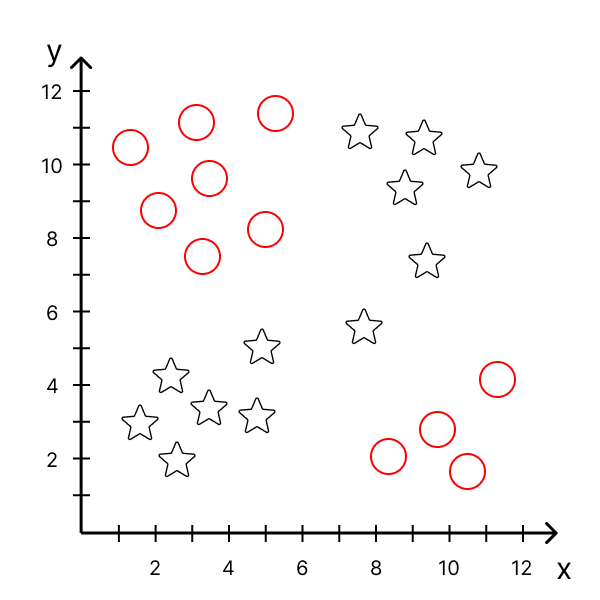

Рисунок 1.

В классическом дереве производится выбор одного признака и порогового значения для построения ортогональной признаку плоскости (в случае с двумя признаками - это прямая), разделяющей пространство признаков на две части.

Выбор признака и порогового значения производится путем максимизации функции [прироста информации (Information Gain)](https://en.wikipedia.org/wiki/Information_gain_(decision_tree)) или коэффициента Джини.

Предположим, что на первой итерации разделения был выбран признак $x$, с пороговым значением $x<7$, тогда визуально на графике (Рисунок 2) первый шаг разделения будет представлен как:

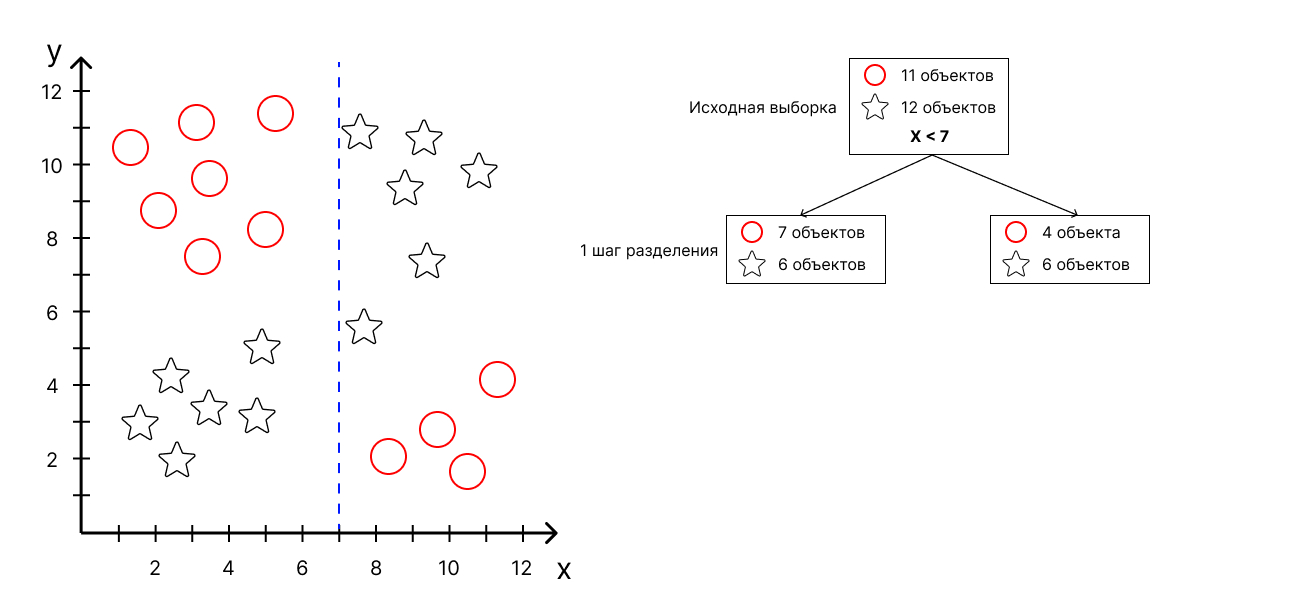

Рисунок 2.

Суть заключается в том, чтобы произвести $n$-ое количество разделений, что в конечном итоге в полученных листах, на последнем шаге всех разделений, объекты будут представлены с минимальным разнообразием (объектов одного класса будет сильно больше, чем объектов другого класса).

Продолжим разделение по новому признаку $y$ с новым порогом $y<6$ (Рисунок 3)

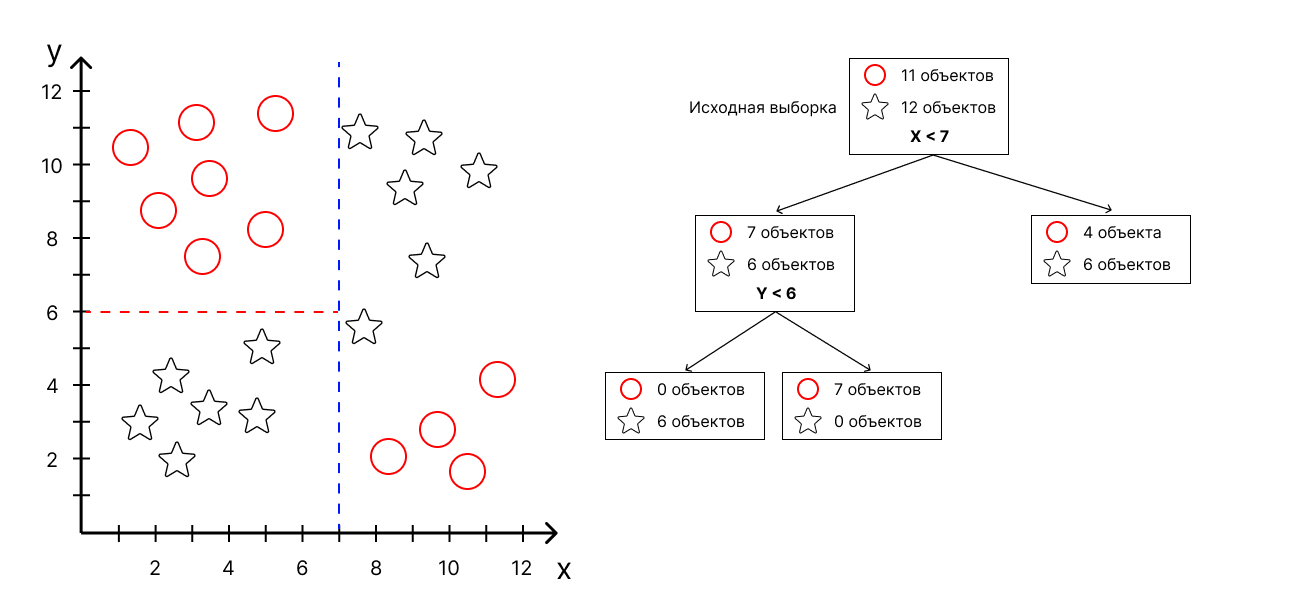

Рисунок 3.

И завершим процесс разделения еще одним шагом из правой ветви дерева по признаку $y$ с пороговым значением $y < 5$ (Рисунок 4)

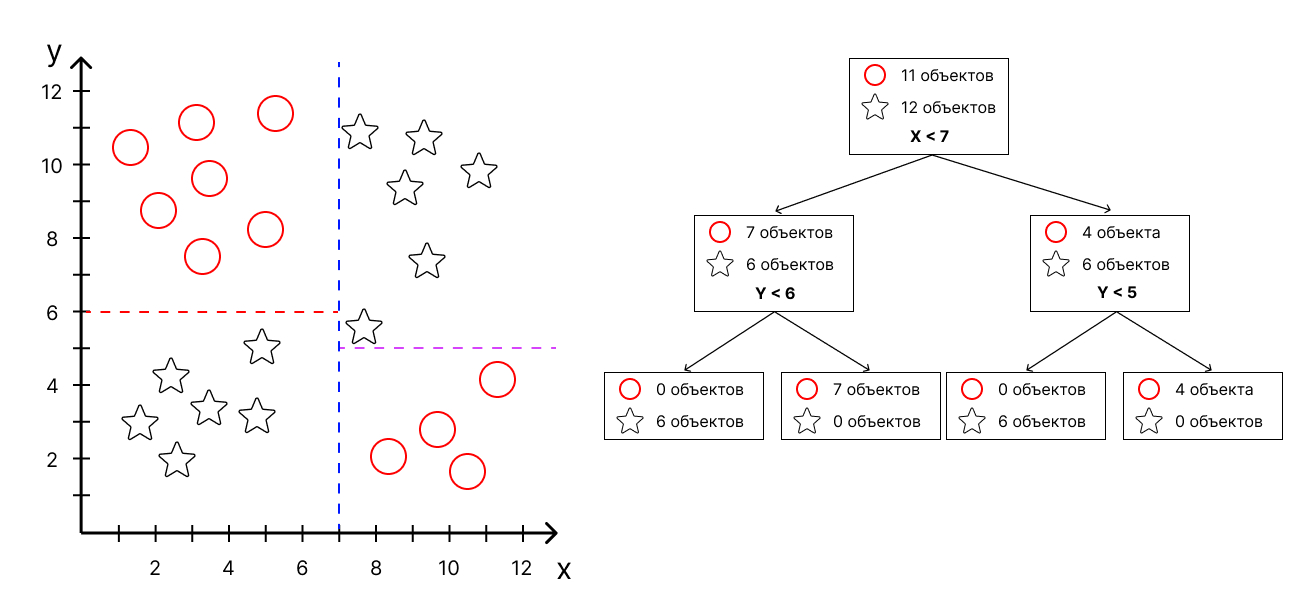

Рисунок 4.

Как и говорилось выше, в случе классификации мы хотим чтобы в лист попало как можно больше объектов одного класса. В случае регрессии добиться как можно меньшей дисперсии ответов для объектов обучающей выборки, попавших в один лист.

Процесс обучения рекурсивен и будет продолжаться до тех пор, пока в листе не останутся объекты только одного класса обучающей выборки (в случае регрессии - пока дисперсия ответов не будет равна нулю), либо пока не наступит один из критериев ограничивающих переобучение:


*   достигнута заданная глубина разделений (n-разделений)
*   достигнуто инимальное заданное значение количества объектов в листке / ветке (n-объектов)
*   прирост информации в результате разделения менее заданного значения - не разделять
*   и другие...



На рисунке 4 показан идеальный случай разделимости. Это произошло из-за природы данных, они были сгенерированы синтетеически для демонтрации работы алгоритма. На практике приходится заниматься перебором критериев и разделяющих порогов чтобы построить наиболее оптимальный набор разделяющих поверхностей.

После обучения данные из тестовой выборки спускаются по веткам в зависимости от выбранного порога по выбранному в процессе обучения признаку. В задаче классификации путем голосования выбирается самый популярный класс из листа, в который попадает объект тестовой выборки. В задаче регрессии ответы усредняются. Благодаря этому появляется возможность интерпретации прогноза на основании исторических данных, которые использовались в процессе обучения дерева.

## Прирост информации

Как упоминалось выше, выбор признака и порогового значения производится путем максимизации функции прироста информации (Information Gain). Но для того чтобы перейти к определению прироста информации нужно разобрать другие понятия как: `комбинаторная энтропия`, `энтропия по Шеннону`.

### Комбинаторная энтропия

Энтропия может интерпретироваться как мера неопределённости (неупорядоченности) или сложности некоторой системы, например, какого-либо опыта (испытания), который может иметь разные исходы, а значит, и количество информации. Таким образом, другой интерпретацией энтропии является нформационная ёмкость системы.

Для того чтобы понять как вычислить комбинаторную энтропию рассмотрим следющий пример (Рисунок 5):

Нам даны 15 шаров разного цвета:

*   4 синих шара
*   5 красных шаров
*   6 зеленых шаров

Для того чтобы вычислить общее количсество возможных перестановок шаров нужно взять факториал от всего количества шаров по формуле $n! = 15!$, но так как шары одного и того же класса между собой не различимы (имеют одинаковый размер, цвет), то нужно использовать отношение факториала общего числа элементов в выборке к произведению факториалов количества элементов каждого класса:

$W=\frac{15!}{4! ⋅ 5! ⋅ 6!}$

где $W$ - мультиномиальный коэффициент.

Для того чтобы пронумеровать все перестановки от 1 до $W$ потребуется $log_2(W)$ бит.

Среднее количество бит для кодировки одного элемента перестановки и будет являться формулой комбинаторной энтропии:
$$S = \frac{log_2(W)}{n}$$

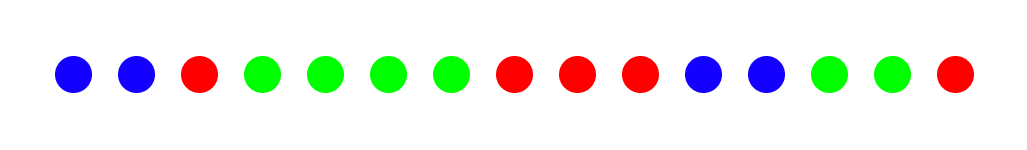

Рисунок 5

### Энтропия по Шеннону

Вычисление факториалов при больших значениях элементов будет затруднительным. Для того чтобы оптимизировать процесс использования вычислительных мощностей прибегают к другой функции, которая очень хорошо приближает формулу комбинаторной энтропии и проще в части вычисления, так как мы уходим от факториалов. Этой формулой является энтропия по Шеннону ([Определение и вывод, можно посмотреть на wiki](https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%8D%D0%BD%D1%82%D1%80%D0%BE%D0%BF%D0%B8%D1%8F)).

Формула энтропии по Шеннону будет иметь вид: $$-K \sum_{i=1}^n(p_ilog_2p_i)$$

где K - положительная константа (и в действительности нужна только для выбора единицы измерения энтропии; изменение этой константы равносильно изменению основания логарифма).


По этой формуле мы можем посчитать прирост энтропии при разбиении исходной выборки на рисунке 5 на две подвыборки (Рисунок 6):

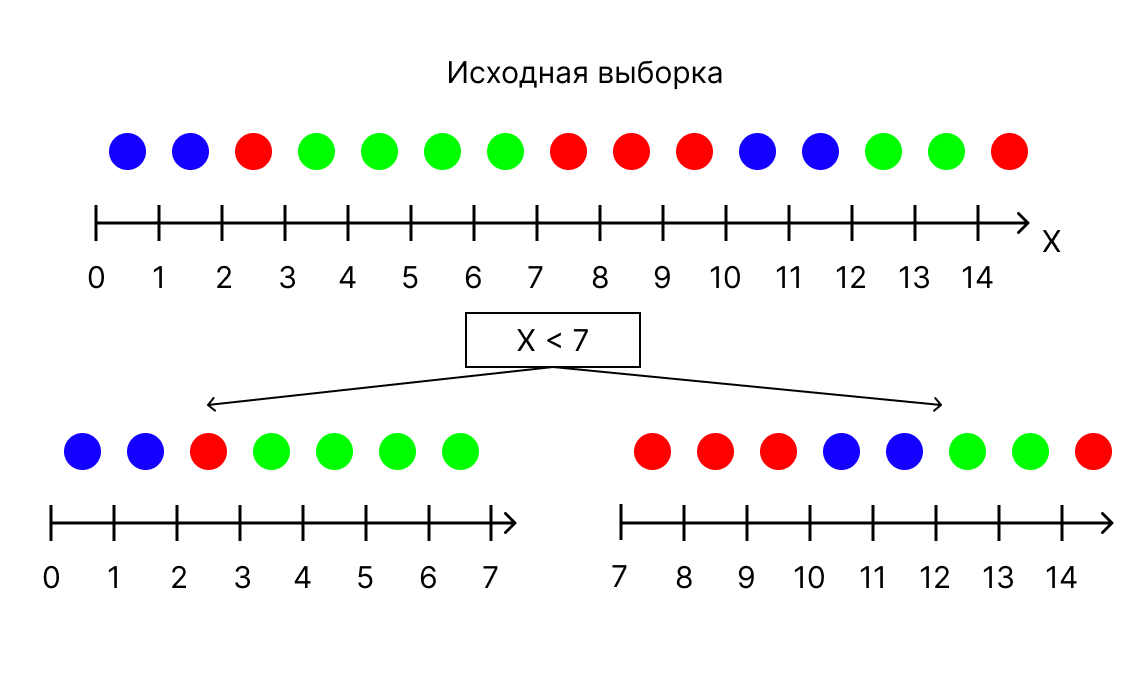

Рисунок 6

Энтропия исходной выборки: $S_0 = -\frac{4}{15} \cdot Ln(\frac{4}{15})-\frac{5}{15} \cdot Ln(\frac{5}{15})-\frac{6}{15} \cdot Ln\frac{6}{15} ≈ 1,06$

Энтропия для левой подвыборки: $S_1 = -\frac{2}{7} \cdot Ln(\frac{2}{7}) - \frac{1}{7} \cdot Ln(\frac{1}{7}) - \frac{4}{7} \cdot Ln(\frac{4}{7}) ≈ 0,96$

Энтропия для правой подвыборки: $S_2 = -\frac{4}{8} \cdot Ln(\frac{4}{8}) - \frac{2}{8} \cdot Ln(\frac{2}{8}) - \frac{2}{8} \cdot Ln(\frac{2}{8}) ≈ 1,04$

>В реальных реализациях в формулу добавили бы маленькое число, например $1 ⋅ 10^{-6}$ чтобы избежать неопределенности при вычислении логарифма при самом удачном случае когда в подвыборку в результате разбиения попали объекты только одного класса.

Тогда прирост информации в результате разбиения можем рассчитать как:

$$IG(Q) = S_0 - \sum_{i=1}^q\frac{N_i}{N} \cdot S_i$$

где:

*   $S_0$ - Энтропия по Шеннону для исходной выборки
*   $S_i$ - Энтропии по Шеннону для подвыборок
*   $N, N_i$ - количество элементов в исходной выборке и подвыборках

В итоге получаем численный прирост информации:  $$1,06 - \frac{7}{15} \cdot 0,96 - \frac{8}{15} ⋅ 1,04 ≈ 0,058$$



В результате разделения энтропия осталась высокой, а прирост информации незначителен. Это означает, что подвыборки в целом сохранили неопределенность относительно классов внутри них.

## Заключение

Дерево принятия решений это универсальный алгоритм, который может использоваться для решения задач классификации и регрессии, но стоит отметить, что этот алгоритм можно легко переобучить, если некорректно установить параметры обучения (например указать слишком большую глубину). Однако это было исправлено в следующих реализациях алгоритма, а именно в другом алгоритме под названием "случайный лес".

Плюс этого алгоритма заключается в том, что данные могут не проходить процедуру стандартизации, а категориальные признаки могут не кодироваться, так как это не даст никакого прироста по метрике качества, а в случае кодирования категориальных признаков только лишь увеличит время обучения.